In [1]:
import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Input,Multiply,RepeatVector,TimeDistributed,Add,Concatenate
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import random
import pandas as pd
import spectrogram
import MGD
import get_features
import importlib
import helper
import FCNN
import mix_noise
importlib.reload(mix_noise)
importlib.reload(spectrogram)
importlib.reload(get_features)
importlib.reload(MGD)
importlib.reload(helper)
importlib.reload(FCNN)
import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow import keras
import json
from sklearn.metrics import f1_score
import mix_noise
from keras.regularizers import l2


Using TensorFlow backend.


In [2]:
#get data from RAVDESS
fft_len=25 
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

random_df = pd.read_pickle('/scratch/lnw8px/RAVDESS_data/dataset_random.pkl')

#use only strong intensity
random_df=random_df[random_df['intensity']=='02']
#drop some emotions
random_df = random_df[(random_df['emotion']!='07')]
uniques=random_df['emotion'].unique()
#uniques=np.sort(uniques)
print(uniques)
for i in range(0,uniques.shape[0]):
    #i+1 because the onehot thinks index starts with 1. 
    random_df.loc[random_df['emotion']==uniques[i],'emotion']=str(i+1)
onehot=random_df['emotion'].apply(helper.to_onehot,args=(7,))
random_df['label']=onehot    
    

break_index=int(random_df.shape[0]*0.7)
train_df=random_df[0:break_index]
train_df=helper.get_noise2_data(train_df)
vali_df=random_df[break_index:-1]

train_list=helper.get_comb2_data_list(train_df,fft_len,fft_hop,height)
class_weights=helper.get_class_weights(train_df)
vali_list=helper.get_comb2_data_list(vali_df,fft_len,fft_hop,height)

['06' '08' '03' '02' '05' '04']


In [3]:
random_df.shape

(576, 6)

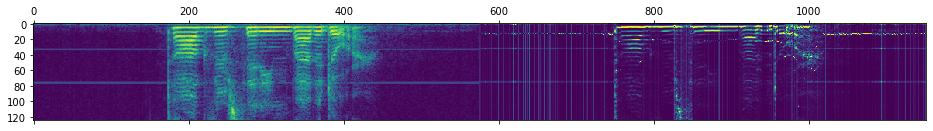

In [20]:
plt.matshow(train_list[2001][0])

In [ ]:
#**************************
#***batch training for RAVDESS dataset
#**************************

#train MGD models
#MGD data
fft_len=25 
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)
bs=16

path='/scratch/lnw8px/results/RAVDESS/ignore_emo/'
file_path=path+'train_results_no_7.txt'
max_acc=0 
model_path=path+'best_model_batch_no_7.h5'
model=FCNN.get_FCNN_attention_exp()
lr=float(K.get_value(model.optimizer.lr))

res_list=[]
decay=1e-6
for i in range(0,10000000):
    batch_data,batch_labels=helper.get_batch(train_list,max_bs=bs)
    #batch_data=helper.add_random_noise(batch_data)
    res=model.train_on_batch(x=batch_data,y=batch_labels,class_weight=class_weights)        
    res_list.append(res)

    if(i>0 and (i%(int(500/bs))==0)):
        if(lr<1e-4):
            break
        f = open(file_path, "a")
        train_res=np.mean(np.array(res_list),axis=0)
        res_list=[]
        acc,f1,f1_list=helper.get_vali_acc(model,vali_list)
        if(acc>max_acc):
            max_acc=acc
            #save the model
            model.save(model_path)
            f.write("saved model. \n")
            f.write("train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
            print("train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
        #reduce learning rate
        K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
        f.close()
        res_list=[]     

/home/lnw8px/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train_acc=0.15820312 vali results=0.20930232558139536



In [ ]:
#**************************
#***batch training for EMo DB
#**************************

#train MGD models
#MGD data
fft_len=25 
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)
bs=16

path='/scratch/lnw8px/results/emo_db_batch/'
file_path=path+'train_results_1.txt'
for fold in range(1,10):
    print(fold)
    max_acc=0 
    model_path=path+'fold_1_'+str(fold)+'.h5'
    print(model_path) 
    train_df,vali_df=helper.get_fold(fold=fold)
    train_df=helper.get_noise2_data(train_df)
    train_list=helper.get_comb2_data_list(train_df,fft_len,fft_hop,height)
    class_weights=helper.get_class_weights(train_df)
    vali_list=helper.get_comb2_data_list(vali_df,fft_len,fft_hop,height)

    model=FCNN.get_FCNN_attention_exp()
    lr=float(K.get_value(model.optimizer.lr))
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        batch_data,batch_labels=helper.get_batch(train_list,max_bs=bs)
        #batch_data=helper.add_random_noise(batch_data)
        res=model.train_on_batch(x=batch_data,y=batch_labels,class_weight=class_weights)        
        res_list.append(res)
        
        if(i>0 and (i%(int(500/bs))==0)):
            if(lr<1e-4):
                break
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1,f1_list=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
                print("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
            #reduce learning rate
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f.close()
            res_list=[]     

In [ ]:
#train MGD models
#MGD data
fft_len=25 
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

path='/scratch/lnw8px/results/new_attention/'
file_path=path+'train_results_sgd.txt'
for fold in range(0,10):
    print(fold)
    max_acc=0
    model_path=path+'fold_'+str(fold)+'.h5'
    print(model_path)
    train_list,vali_list,class_weights=helper.get_mag_fold(fold,fft_len,fft_hop,height)
    model=FCNN.get_FCNN_new()
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        data,label=helper.get_random_sample(train_list)
        res=model.train_on_batch(x=data,y=label,class_weight=class_weights)
        res_list.append(res)
        if(i>0 and (i%500==0)):
            lr=float(K.get_value(model.optimizer.lr))
            if(lr<1e-5):
                break
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
                print("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
            f.close()
            res_list=[]     

In [ ]:
#train MGD+spec side by side (comb2)  models
fft_len=25
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

path='/scratch/lnw8px/results/all_FCNN/attention_models/att_exp/att_24/filt_4/'
file_path=path+'train_results.txt'
for fold in range(0,10):
    print(fold)
    max_acc=0
    model_path=path+'fold_'+str(fold)+'.h5'
    print(model_path)
    train_data,vali_df,class_weights=helper.get_noise2_fold_data(fold=fold)
    train_list=helper.get_comb2_data_list(train_data,fft_len,fft_hop,height)
    vali_list=helper.get_comb2_data_list(vali_df,fft_len,fft_hop,height)
    model=FCNN.get_FCNN_attention_exp(filt_size=4,att_filt_num=24)
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        data,label=helper.get_random_sample(train_list)
        res=model.train_on_batch(x=data,y=label,class_weight=class_weights)
        res_list.append(res)
        if(i>0 and (i%500==0)):
            lr=float(K.get_value(model.optimizer.lr))
            if(lr<1e-5):
                break
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+ " lr = " + str(lr)+"\n")
            f.close()
            res_list=[]     

In [ ]:
#train MGD+spec side by side (comb2)  models

fft_len=25
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

path='/scratch/lnw8px/results/all_FCNN/attention_models/comb2/fft_25_flt_16/'
file_path=path+'train_results.txt'
for fold in range(5,10):
    print(fold)
    max_acc=0
    model_path=path+'fold_'+str(fold)+'.h5'
    print(model_path)
    train_list,vali_list,class_weights=helper.get_comb2_fold_features(fold,fft_len,fft_hop,height)
    model=FCNN.get_FCNN_attention_exp(num_channels=1,filt_size=3)
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        data,label=helper.get_random_sample(train_list)
        res=model.train_on_batch(x=data,y=label,class_weight=class_weights)
        res_list.append(res)
        if(i>0 and (i%500==0)):
            lr=float(K.get_value(model.optimizer.lr))
            if(lr<1e-5):
                break
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+ " lr = " + str(lr)+"\n")
            f.close()
            res_list=[]     

In [ ]:
fft_len=25
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)


#train MGD+spec side by side (comb1)  models
path='/scratch/lnw8px/results/all_FCNN/comb1/fft_25/'
file_path=path+'train_results.txt'
for fold in range(0,10):
    print(fold)
    max_acc=0
    model_path=path+'fold_'+str(fold)+'.h5'
    print(model_path)
    train_list,vali_list,class_weights=helper.get_comb1_fold_features(fold,fft_len=fft_len,fft_hop=fft_hop,height=height)
    model=FCNN.get_FCNN_attention(num_channels=2,filt_size=3)
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        data,label=helper.get_random_sample(train_list)
        res=model.train_on_batch(x=data,y=label,class_weight=class_weights)
        res_list.append(res)
        if(i>0 and (i%500==0)):
            lr=float(K.get_value(model.optimizer.lr))
            if(lr<1e-5):
                break
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+ " lr = " + str(lr)+"\n")
            f.close()
            res_list=[]     

In [ ]:
#train MGD+spec side by side (comb2)  models
path='/scratch/lnw8px/results/all_FCNN/MGD/fft_25/'
file_path=path+'spec_results.txt'
for fold in range(0,10):
    print(fold)
    max_acc=0
    model_path=path+'fold_'+str(fold)+'.h5'
    print(model_path)
    train_list,vali_list,class_weights=get_MGD_fold_features(fold)
    model=FCNN.get_FCNN(num_channels=1,filt_size=3)
    
    res_list=[]
    decay=1e-6
    for i in range(0,10000000):
        data,label=helper.get_random_sample(train_list)
        res=model.train_on_batch(x=data,y=label,class_weight=class_weights)
        res_list.append(res)
        if(i>0 and (i%500==0)):
            lr=float(K.get_value(model.optimizer.lr))
            if(lr<1e-6):
                break
            K.set_value(model.optimizer.lr, lr*(1/(1+decay*i)))
            f = open(file_path, "a")
            train_res=np.mean(np.array(res_list),axis=0)
            res_list=[]
            acc,f1=helper.get_vali_acc(model,vali_list)
            if(acc>max_acc):
                max_acc=acc
                #save the model
                model.save(model_path)
                f.write("saved model. \n")
                f.write("fold="+str(fold)+" train_acc=" + str(train_res[1]) + " vali results=" + str(acc)+"\n")
            f.close()
            res_list=[]     